## Setting up a 2D retention model

In this notebook we will:
- Set up a virtual LCxLC (2DLC) system, using retention modelling.
- Sample retention parameters for a 2DLC retention model.
- Introduce an Online and Offline 2DLC system. Here the online system will be considered to be the real, groundtruth, 2DLC system, whereas the offline system will be a biased version of the online system, which will not have all compounds in its model, and will predict noisy retention times and peak widths
- We then analyse the correlation between the online and offline system and assess the introduced errors by the offline model.

The results of this notebook are discussed in Section XX of ..... For more information, please check out this section.

We start out with importing the required packages

In [129]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from bo_code.BO import generate_initial_data

from rm_code.retention_model import online_system, offline_system, offline_system2
from rm_code.plot_chromatogram import plot_chromatogram, plot_contour_spectrum,  plot_shifting_2D_gradient

from utils.utils import bo_to_rm_2D, check_pars, seed_everything

from tqdm import tqdm
import pandas as pd

## Setting up the retention model

In this cell we will set up all values related to the 2DLC sytem, such as dead time, dwell time, plate number, modulation time, etc.
In addition, we set 1D and 2D parameters for a simple linear gradient in the first dimension, and a second dimension gradient program without a gradient shift, for later use. Lastly we set maximum times in the first and second dimension (max_T), which will be thresholds for the evaluation of objective functions later.

In [131]:
### Set up a 1D retention model

# Set some default parameters for first dimension
t_0_1D = 4.5 # dead time
t_D_1D = 0.1 # dwell time
N_1D = 400 # plate number 1D
t_init_1D = 2 # init time

# create dictionary for the above described parameters
settings_1D = {'t_0': t_0_1D, 't_D': t_D_1D, 'N': N_1D, 't_init': t_init_1D}

### Set up a 2D retention model

### Define 2D parameters
N_2D = 100000 # plate number 2D

t_M_2D = 2 #/ 3 # modulation time minutes
t_G_2D = 1.8 #/ 3 # gradient time minutes
t_init_2D = 0.1 #/ 3 # init time minutes
t_D_2D = 0.01 # dwell time in minutes
t_0_2D = 0.01 # dead time in minutes

# create dictionary for the above described parameters
settings_2D = {'t_M': t_M_2D, 't_G': t_G_2D, 't_init': t_init_2D, 't_D': t_D_2D, 't_0': t_0_2D, 'N': N_2D}

# Try out a 1D gradient
phi_list_1D = [0, 0.25, 0.5, 1] # phi values
t_list_1D = [0, 25, 50, 100] # time values

# Try out a shifting gradient
phi_init_2D = [0.0, 0.0, 0.0, 0.0, 0.0] # lower bounds of gradient shift
phi_final_2D = [1, 1, 1, 1, 1] # upper bounds of gradient shift
t_list_2D = [0, t_0_1D, 40, 45, t_list_1D[-1]] # time points of gradient shift

# maximum allowed times in first and second dimension. compounds that elute after this time are ignored in the objective function evaluation.
max_T = [100, t_M_2D]

# check if the parameters are valid
check_pars(settings_2D, t_list_1D, phi_init_2D, phi_final_2D, t_list_2D)


## Sampling retention parameters

We will now sample retention parameters for the "analytes" in the retention model.

### First dimension
In the first dimension we will first sample 40 analytes. We sample k0 values uniformly between [200, 700] and S values uniformly between [14, 24]. We then take these values and multiply the k0 values with $e^{1.5}$ and multiply S values with 0.4. This effectively creates a sample where the first distribution of 40 analytes elute under relatively low modifier concentrations, whereas the second distribution of analytes elutes at significantly higher modifier concentrations. Therefore, the required measurement time in the first dimension can be improved by having two linear gradient segments for each distribution.

### Second dimension
In the second dimension, for simplicity, we use the same S values as in the first dimension.
For the k0 values, we add a value drawn uniformly between [0, 1000] for the first 40 analytes, to make them elute slower in the second dimension, and thus give better seperability there. For the last 40 analytes, we add a value drawn uniformly between [-300, 300].


In [151]:
# TODO: remove left over sampling stuff

# Create a "real" system
# set random seed for reproducibility
seed_everything(4242)

# number of analytes
n_analytes = 80

# sample 1D parameters
#S_list_1D = np.random.uniform(2, 16, n_analytes)
S_list_1D = np.random.uniform(15, 25, n_analytes//2)
k0_list_1D = np.random.uniform(200, 700, n_analytes//2)

#k0_list_2D = k0_list_1D + np.random.uniform(0, 100, len(k0_list_1D))
# use normal sampling
# k0_list_1D = np.random.normal(950, 200, n_analytes)
# S_list_1D = np.random.normal(24, 4, n_analytes)

# add second distribution with slower eluting compounds
k0_list_1D = np.concatenate((k0_list_1D, list(np.multiply(k0_list_1D, np.exp(1.5)))), axis=0)
S_list_1D = np.concatenate((S_list_1D, np.multiply(S_list_1D, 0.4)), axis=0)
#
# # add heteroscedastic noise to k0_list_1D
# k0_list_2D = k0_list_1D + np.random.normal(0, k0_list_1D/6, len(k0_list_1D))  # heteroscedastic noise
# S_list_2D = S_list_1D + np.random.normal(0, S_list_1D/6, len(S_list_1D))  # heteroscedastic noise

# sample 2D parameters
k0_list_2D = [0 for i in range(n_analytes//2)]
k0_list_2D[0:40] = k0_list_1D[0:40] + np.random.uniform(0, 1000, len(k0_list_1D[0:40]))
k0_list_2D[40:] = k0_list_1D[40:] + np.random.uniform(-300, 300, len(k0_list_1D[40:]))
S_list_2D = [0 for i in range(n_analytes//2)]
S_list_2D[0:40] = S_list_1D[0:40] + np.random.uniform(-3, 0, len(S_list_1D[0:40]))
S_list_2D[40:] = S_list_1D[40:] + np.random.uniform(-1, 2, len(S_list_1D[40:]))

# sample 2D parameters uncorrelated from 1D pars
#S_list_2D = np.random.uniform(14, 24, n_analytes)
#k0_list_2D = np.random.uniform(200, 700, n_analytes)
#k0_list_2D = np.concatenate((k0_list_2D, list(np.multiply(k0_list_2D, np.exp(1.5)))), axis=0)
#S_list_2D = np.concatenate((S_list_2D, np.multiply(S_list_2D, 0.4)), axis=0)

# add all the retention parameters to a dictionary
ret_pars = {'k0_1D': k0_list_1D, 'S_1D': S_list_1D, 'k0_2D': k0_list_2D, 'S_2D': S_list_2D}

# write parameters to a file, will be read in by other notebooks later.
df = pd.DataFrame(ret_pars)
df.to_csv('data/retention_system.csv', index=False)

## Correlation between retention parameters

Here we show plots of the k0 and S parameters of first dimension versus the second dimension.
Here it can be seen that the k0 values between the first and second dimension still are fairly correlated, as would be expected for 2DLC systems using reversed phase columns in both dimensions.

If a fully orthogonal system is desired, sample k0 and S independently of each other.

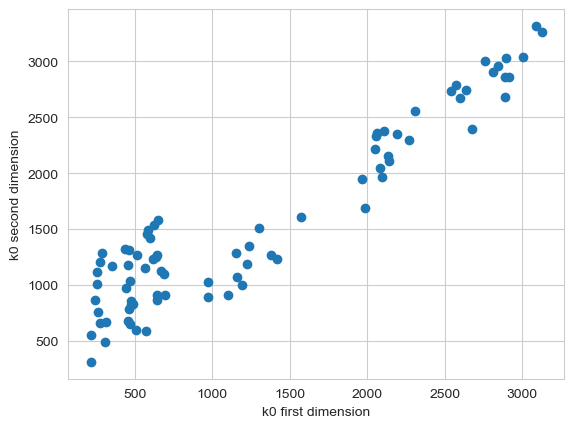

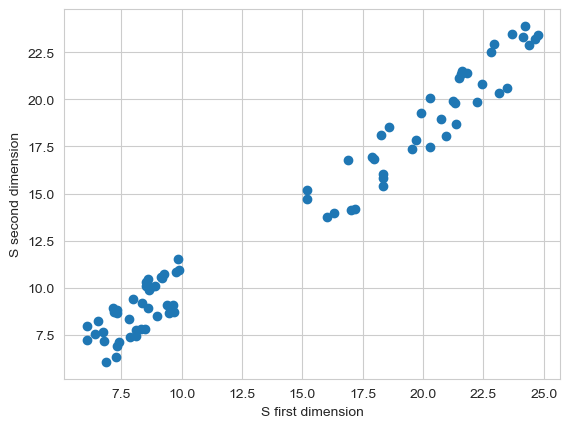

In [133]:
plt.scatter(k0_list_1D, k0_list_2D)
plt.xlabel('k0 first dimension')
plt.ylabel('k0 second dimension')
plt.show()
plt.scatter(S_list_1D, S_list_2D)
plt.xlabel('S first dimension')
plt.ylabel('S second dimension')
plt.show()

## Testing out the 2DLC system and retention model

Now that we have defined the settings of the 2DLC system and have generated retention parameters. We can test the system under a simple 1D gradient without any gradient shift in the second dimension (this was defined earlier already).

We also introduce the notion of an online and offline system here. Here we see the online system as the ground-truth real world 2DLC system, and the offline model as the "retention model" of this ground-truth system. We assume the offline model does not contain all analytes that are present in the online model, to sketch the scenario were not all compounds have successfully been tracked over the scanning experiments. Also, we assume the offline system has some error in the prediction of retention times and peak widths (due to hypothesized mistakes in retention parameter estimation), therefore, we add some normal random noise to the predicted retention times and peak widths of the online system to obtain the retention times and peak widths of the offline system.

We evaluate a resolution based objective function on these measurements, where the resolution between two peaks $i$ and $j$ is defined as follows:

\begin{equation}
    R_{S_{i, j}}=\sqrt{\frac{(t^1_{R, i} - t^1_{R,j})^2}{\left[2\left(\sigma^{1}_{i}+\sigma^{1}_{j}\right)\right]^2}+\frac{(t^2_{R, i} - t^2_{R,j})^2}{\left[2\left(\sigma^2_{i}+\sigma^2_{j}\right)\right]^2}}
\end{equation},
where $t^1_{R, i}$, $t^1_{R, j}$, $t^2_{R, i}$, and $t^2_{R, j}$ are the retention times in the first- and second dimension of peak $i$ and $j$, respectively. $\sigma^1_{i}$, $\sigma^1_{j}$, $\sigma^2_{i}$, and $\sigma^2_{j}$ are the corresponding standard deviations of the peaks.

As peaks are generally adequately seperated if their resolution is 1.5, we use the following desirability function to normalize the resolution values between 0 and 1:

\begin{equation}
d\left(Rs_{i,j} \right)=\left\{\begin{array}{c}
\frac{Rs_{i, j}}{1.5} \text{ if } R s_{i, j} < 1.5 \\
1 \text{ if } R s_{i, j} \geq 1.5
\end{array}\right.
\end{equation}

Finally, as an objective function, we use the following equation:
\begin{equation}
    \sum_{i}^{N }\min_{j \neq i} d\left(Rs_{i,j} \right)
\end{equation},
where for each peak $i$, we compute the resolution with their $j\neq i$ neighbours, and pick the lowest value (i.e., its closest neighbour) and summate over these values. This leads to a practical and intuitive objective function, where its value increases monotonically with the number of separated compounds.

Now looking at the chromatograms of the online- and offline system and the values of the objective function,
it can be observed that although the measurements look similar, the difference in objective function score is significant.
It can also be observed that the first and second dimension are relatively correlated, as most peaks are on the diagonal.

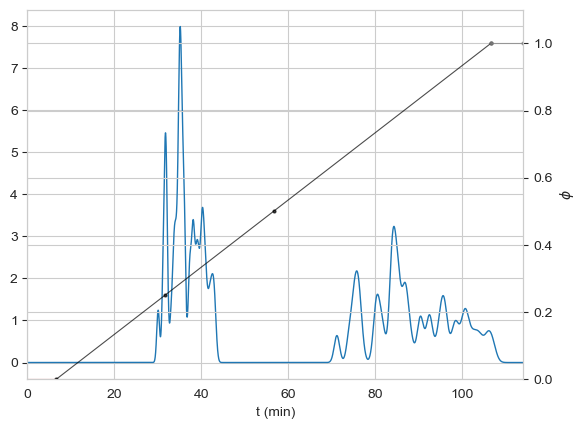

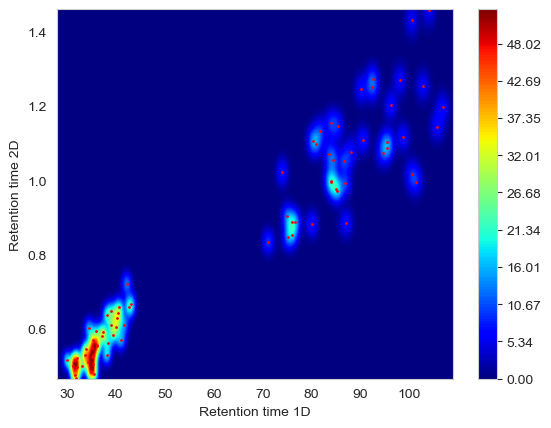

Score Online:  70.29567759335995 106.82538705680172


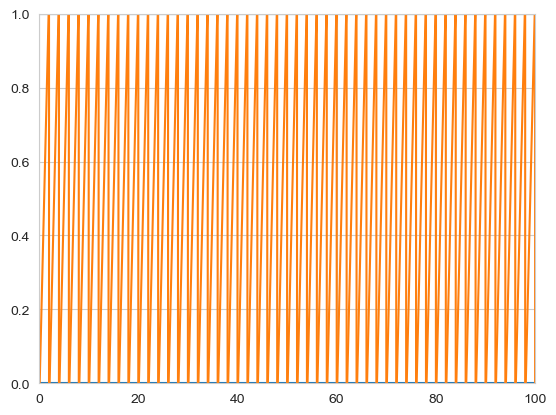

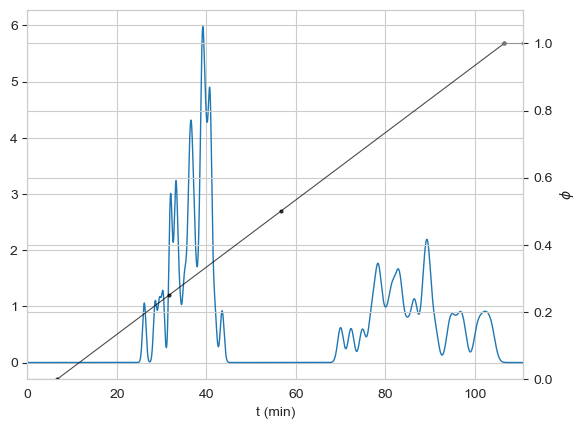

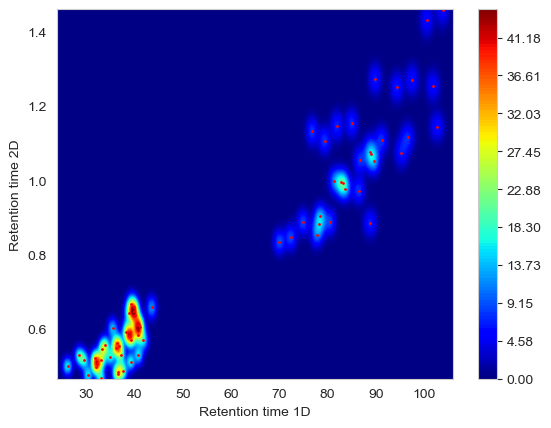

Score Offline:  61.62753373838258 10.378741266252474


In [134]:
# test online_system
tR_list_1D, W_list_1D, tR_list_2D, W_list_2D, res_score, time_score = online_system(ret_pars, settings_1D, settings_2D, phi_list_1D, t_list_1D, phi_init_2D, phi_final_2D, t_list_2D, max_T)

plot_chromatogram(tR_list_1D, W_list_1D, phi_list_1D, t_list_1D, settings_1D)
plot_contour_spectrum(tR_list_1D, tR_list_2D, W_list_1D, W_list_2D, max_T)
plot_shifting_2D_gradient(settings_2D, phi_init_2D, phi_final_2D, t_list_2D)
print('Score Online: ' ,res_score, time_score)
# test offline_system
# draw 10 random indices between 0 and 2*n_analytes
remove_indices = np.random.randint(0, n_analytes, 15)
# create dictionary with noise levels
noise = {'tR_1D': 2, 'tR_2D': 0.3, 'W_1D': 0.2, 'W_2D': 0.05}

tR_list_1D, W_list_1D, tR_list_2D, W_list_2D, res_score, time_score = offline_system2(ret_pars, settings_1D, settings_2D, phi_list_1D, t_list_1D, phi_init_2D, phi_final_2D, t_list_2D, max_T, noise, remove_indices)
plot_chromatogram(tR_list_1D, W_list_1D, phi_list_1D, t_list_1D, settings_1D)
plot_contour_spectrum(tR_list_1D, tR_list_2D, W_list_1D, W_list_2D, max_T)
print('Score Offline: ' ,res_score, time_score)


### Feel free to try out another gradient program by adjusting the gradient programs in the first and second dimension below

In [150]:
# try out another gradient program here.
phi_list_1D_opt = [0.2, 0.3, 1, 1] # phi values
t_list_1D_opt = [0, 25, 50, 100] # time values

phi_init_2D_opt = [0.1, 0.1, 0.1, 0.3, 0.4] # lower bounds of gradient shift
phi_final_2D_opt = [0.20, 0.20, 0.2, 0.7, 1] # upper bound of gradient shift
t_list_2D_opt = [0, t_0_1D, 30, 50, t_list_1D[-1]] # time points of shifting gradient

check_pars(settings_2D, t_list_1D_opt, phi_init_2D_opt, phi_final_2D_opt, t_list_2D_opt)

# test online_system
tR_list_1D, W_list_1D, tR_list_2D, W_list_2D, res_score, time_score = online_system(ret_pars, settings_1D, settings_2D, phi_list_1D_opt, t_list_1D_opt, phi_init_2D_opt, phi_final_2D_opt, t_list_2D_opt, max_T)

plot_chromatogram(tR_list_1D, W_list_1D, phi_list_1D_opt, t_list_1D_opt, settings_1D)
plot_contour_spectrum(tR_list_1D, tR_list_2D, W_list_1D, W_list_2D, max_T)
plot_shifting_2D_gradient(settings_2D, phi_init_2D_opt, phi_final_2D_opt, t_list_2D_opt)

print('Score: ' ,res_score, time_score)

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

## Comparing online and offline system

We will now generate a wide range of gradient programs, and evaluate these programs on the online and offline system and compare objective function scores.
We consider the following parameters for the gradient program in the first dimension:

Time program = $[t_{0} , t_{1}, t_{2}, t_{3}]$

Modifier program = $[\varphi_{0}, \varphi_1, \varphi_2, \varphi_{3}]$

Where we keep the start and the end of the gradient program fixed (i.e., $t_{0}=0, t_{3}=100 min, \varphi_{0}=0, \varphi_{3}=1$)

For the second dimension, we consider the following parameters:

Shifting time program = $[0, t_{shift, 0}, t_{shift, 1}, t_{shift, 2}, t_{shift, 3}]$

Initial modifier concentrations of the gradient shift = $[\varphi_{init, 0}, \varphi_{init, 0}, \varphi_{init, 1}, \varphi_{init, 2}, \varphi_{init, 3}]$

Final modifier concentrations of the gradient shift = $[\varphi_{final, 0}, \varphi_{final, 0}, \varphi_{final, 1}, \varphi_{final, 2}, \varphi_{final, 3}]$

Here, we also keep the start and the end of the shifting gradient fixed, so that:

$t_{shift, 0}=0, t_{shift, 1}=t_{init}, t_{shift, 4} = 100 min, \varphi_{init, 0} = 0$, and $\varphi_{final, 3}$ = 1.

This then leads to the following input vector for which we need to sample parameters:
$[\varphi_{1}, \varphi_{2}, t_{1}, t_{2}, \varphi_{init, 1}, \varphi_{init, 2}, \varphi_{init, 3}, \varphi_{final, 0}, \varphi_{final, 1}, \varphi_{final, 2}, t_{shift, 2}, t_{shift, 3}]$

To obtain valid method parameters, we set bounds so that time points are between 0 and 100 min, and modifier concentrations are between 0 and 1.
To ensure reasonable gradient programs, where time points are ordered and gradient profiles are increasing, we set the following inequality constraints:

$\varphi_1 \le \varphi_2 + 0.1$

$t_1 \le t_2$

$\varphi_{init, 1} \le \varphi_{final, 1}$

$\varphi_{init, 2} \le \varphi_{final, 2}$

$t_{shift, 2} \le t_{shift, 3}$

We can then sample from this parameter space using Polytope sampling. We sample 200 sets of method parameters and compute the objective function scores for both the online and offline system. As the offline system is stochastic, we evaluate the method parameters 3 times to get an estimate of the mean and variance of the prediction of the offline system.



In [146]:
t_max = 100 # maximum time
phi_min, phi_max = 0, 1 # maximum phi

fixed_phi_pars_1D = torch.tensor([[phi_min], [phi_max]]) # fixed phi points
fixed_time_pars_1D = torch.tensor([[0.], [t_max]]) # at fixed time points

fixed_phi_pars_2D = torch.tensor([[phi_min], [phi_max]]) # fixed phi points
fixed_time_pars_2D = torch.tensor([[0.],[t_0_1D], [t_max]]) # at fixed time points

# I want to sample a bunch of parameters using generate_initial_data()
bounds = torch.stack([
    torch.tensor([phi_min, phi_min, 0.1, 0.1, phi_min, phi_min, phi_min, phi_min, phi_min, phi_min, t_0_1D, t_0_1D]),
    torch.tensor([phi_max, phi_max, t_max-0.1, t_max-0.1, phi_max, phi_max, phi_max, phi_max, phi_max, phi_max, t_max-t_M_2D, t_max-t_M_2D])]
)

inequality_constraints= [(torch.tensor([0,1]), torch.tensor([-1., 1.]), 0.0), (torch.tensor([2,3]), torch.tensor([-1., 1.]), 0.1), (torch.tensor([10,11]), torch.tensor([-1., 1.]), t_M_2D), (torch.tensor([4,8]), torch.tensor([-1., 1.]), 0.0), (torch.tensor([5,9]), torch.tensor([-1., 1.]), 0.0)]

# sample a bunch of parameters
pars = generate_initial_data(200, bounds, inequality_constraints)

# convert to parameters that retention modeling code can handle
phi_list_1D, t_list_1D, phi_list_init, phi_list_final, t_list_2D = bo_to_rm_2D(pars, fixed_phi_pars_1D, fixed_time_pars_1D, fixed_phi_pars_2D, fixed_time_pars_2D)

In [147]:
# plot online vs. offline with mean and std of offline evaluations
scores_online = []
scores_offline = []
time_scores_online = []
time_scores_offline = []
scores_online_wtime = []
scores_offline_wtime = []

repeats = 2
print(len(remove_indices))
for i in tqdm(range(len(pars))):
    # use online system
    tR_list_1D, W_list_1D, tR_list_2D, W_list_2D, res_score, time_score = online_system(ret_pars, settings_1D, settings_2D, phi_list_1D[i], t_list_1D[i], phi_list_init[i], phi_list_final[i], t_list_2D[i], max_T)
    scores_online_wtime.append(res_score - 0.2*time_score)
    time_scores_online.append(time_score)
    scores_online.append(res_score)

    for j in range(repeats):
        # use offline system
        tR_list_1D, W_list_1D, tR_list_2D, W_list_2D, res_score, time_score = offline_system2(ret_pars, settings_1D, settings_2D, phi_list_1D[i], t_list_1D[i], phi_list_init[i], phi_list_final[i], t_list_2D[i], max_T, noise, remove_indices)
        scores_offline.append(res_score)
        time_scores_offline.append(time_score)
        scores_offline_wtime.append(res_score - 0.2*time_score)

scores_offline = np.reshape(scores_offline, (len(pars), repeats))
scores_offline_wtime = np.reshape(scores_offline_wtime, (len(pars), repeats))
scores_online = np.reshape(scores_online, (len(pars), 1))
scores_online_wtime = np.reshape(scores_online_wtime, (len(pars), 1))
time_scores_online = np.reshape(time_scores_online, (len(pars), 1))
time_scores_offline = np.reshape(time_scores_offline, (len(pars), repeats))

# compute mean and std of offline scores
scores_offline_mean = np.mean(scores_offline, axis=1, keepdims=True)
scores_offline_wtime_mean = np.mean(scores_offline_wtime, axis=1, keepdims=True)
scores_offline_std = np.std(scores_offline, axis=1, keepdims=True)
scores_offline_wtime_std = np.std(scores_offline_wtime, axis=1, keepdims=True)
time_scores_offline_mean = np.mean(time_scores_offline, axis=1, keepdims=True)
time_scores_offline_std = np.std(time_scores_offline, axis=1, keepdims=True)


15


100%|██████████| 200/200 [01:15<00:00,  2.66it/s]


We will now plot the online scores versus the offline scores. The orange line shows the 1:1 diagonal.
As described in the paper the objective function is defined as follows:

It can be seen that at low online score values, the offline system is overconfident in its score, possibly due to the fact that analytes that are overlapping in the online system, are partially missing and thus not overlapping in the offline system (due to the removed compounds), and hence are contributing to the objective function score. At high online values, on the other hand, the offline system predicts lower scores, due to the fact that it does not contain all analytes that are seperated in the online system. Therefore, guiding the optimization using solely the offline system, will not lead to an optimum of the (ground-truth) online system.

However, it is clear that there is correlation (Pearson correlation printed below) between the offline and online system, and therefore provides useful information which we can exploit in the [next notebook](cross_validation.ipynb)

Pearson correlation:  0.9848099703864474


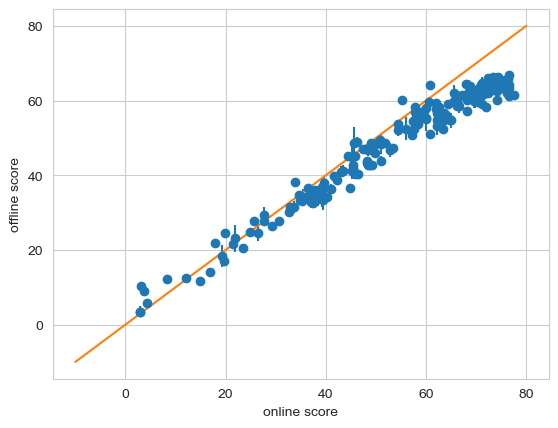

In [148]:
# plot correlation between online and offline scores with error bars
plt.errorbar(scores_online.flatten(), scores_offline_mean.flatten(), yerr=scores_offline_std.flatten(), fmt='o')
plt.plot([-10,80], [-10,80])
plt.xlabel('online score')
plt.ylabel('offline score')

# print correlation coefficient
print('Pearson correlation: ', np.corrcoef(scores_online.flatten(), scores_offline_mean.flatten())[0,1])

Pearson correlation:  0.974817982191684


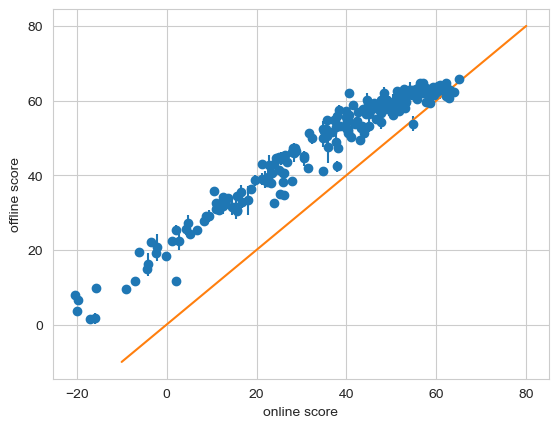

In [149]:
plt.errorbar(scores_online_wtime.flatten(), scores_offline_wtime_mean.flatten(), yerr=scores_offline_wtime_std.flatten(), fmt='o')
plt.plot([-10,80], [-10,80])
plt.xlabel('online score')
plt.ylabel('offline score')

# print correlation coefficient
print('Pearson correlation: ', np.corrcoef(scores_online_wtime.flatten(), scores_offline_wtime_mean.flatten())[0,1])

Pearson correlation:  0.9781347732746788
Pearson correlation:  0.9778684149869947


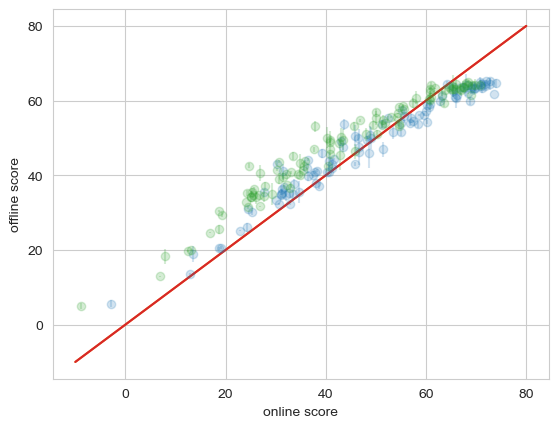

In [145]:
# plot correlation between online and offline scores with error bars
prefac = 0.1
for prefac in [0.05, 0.1]:#,: 0.2, 0.3, 0.4, 0.5]:
    plt.errorbar(scores_online.flatten() - prefac*time_scores_online.flatten(), scores_offline_mean.flatten() - prefac*time_scores_offline_mean.flatten(), yerr=scores_offline_std.flatten()+prefac*time_scores_offline_std.flatten(), fmt='o', alpha=0.2)
    plt.plot([-10,80], [-10,80])
    plt.xlabel('online score')
    plt.ylabel('offline score')

    # print correlation coefficient
    print('Pearson correlation: ', np.corrcoef(scores_online.flatten() - prefac*time_scores_online.flatten(), scores_offline_mean.flatten() - prefac*time_scores_offline_mean.flatten())[0,1])

## Assessing error of the offline system
Lastly we compare the best measurement of the online system with the measurement of the offline system under those method parameters. We then compare the difference in retention time prediction and width prediction and plot these. We also compute the mean absolute percentage error to get a grasp of the magnitude of these introduced errors.

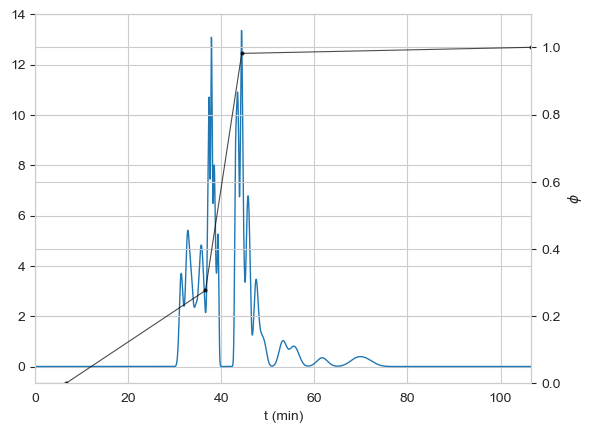

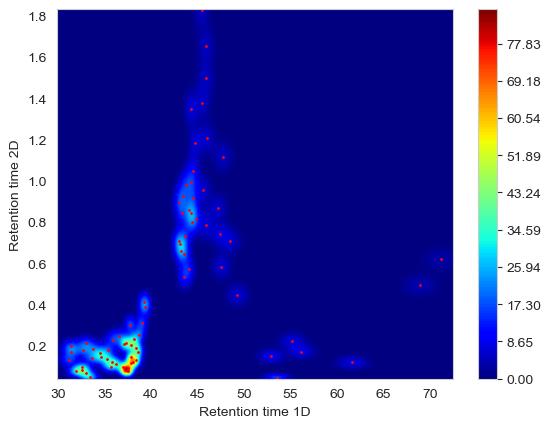

online score:  79.80210856615776


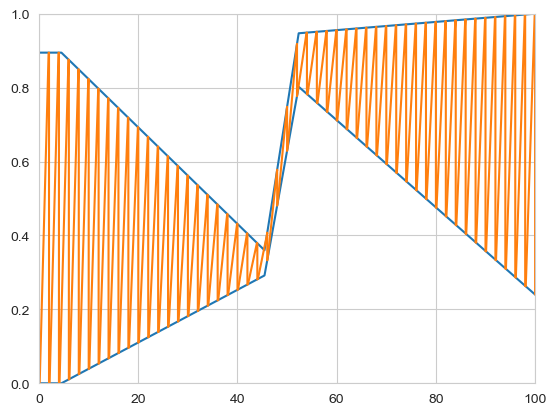

In [127]:
# plot chromatogram of best online score
best_online_index = np.argmax(scores_online_wtime)

tR_list_1D, W_list_1D, tR_list_2D, W_list_2D, res_score, time_score = online_system(ret_pars, settings_1D, settings_2D, phi_list_1D[best_online_index], t_list_1D[best_online_index], phi_list_init[best_online_index], phi_list_final[best_online_index], t_list_2D[best_online_index], max_T)

plot_chromatogram(tR_list_1D, W_list_1D, phi_list_1D[best_online_index], t_list_1D[best_online_index], settings_1D)
plot_contour_spectrum(tR_list_1D, tR_list_2D, W_list_1D, W_list_2D, max_T)
plot_shifting_2D_gradient(settings_2D, phi_list_init[best_online_index], phi_list_final[best_online_index], t_list_2D[best_online_index])

print('online score: ', res_score)
# rename to online version
tR_list_1D_online = tR_list_1D
W_list_1D_online = W_list_1D
tR_list_2D_online = tR_list_2D
W_list_2D_online = W_list_2D


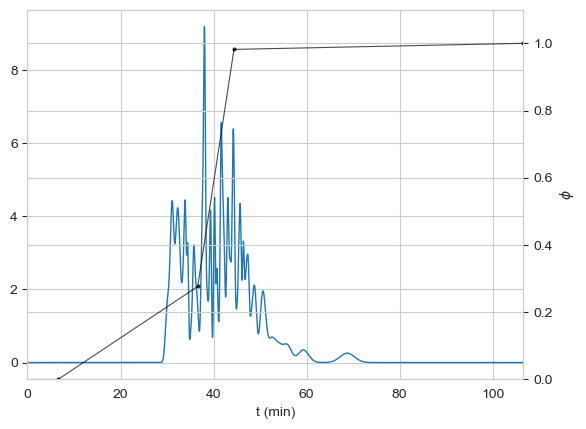

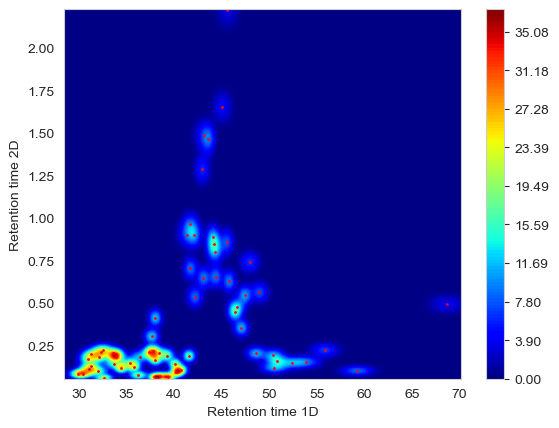

63.66078032066907


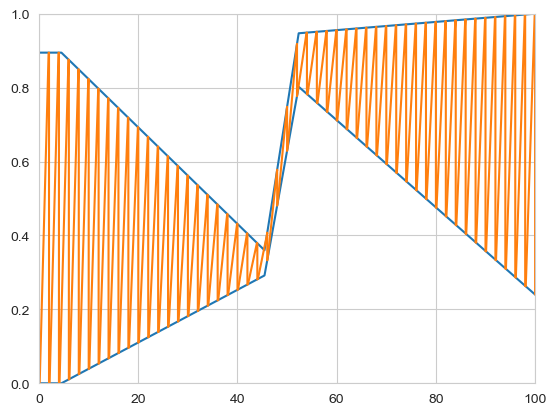

In [128]:
# plot offline system at best online score
tR_list_1D, W_list_1D, tR_list_2D, W_list_2D, res_score, time_score = offline_system2(ret_pars, settings_1D, settings_2D, phi_list_1D[best_online_index], t_list_1D[best_online_index], phi_list_init[best_online_index], phi_list_final[best_online_index], t_list_2D[best_online_index], max_T, noise, remove_indices)

plot_chromatogram(tR_list_1D, W_list_1D, phi_list_1D[best_online_index], t_list_1D[best_online_index], settings_1D)
plot_contour_spectrum(tR_list_1D, tR_list_2D, W_list_1D, W_list_2D, max_T)
plot_shifting_2D_gradient(settings_2D, phi_list_init[best_online_index], phi_list_final[best_online_index], t_list_2D[best_online_index])

print(res_score)


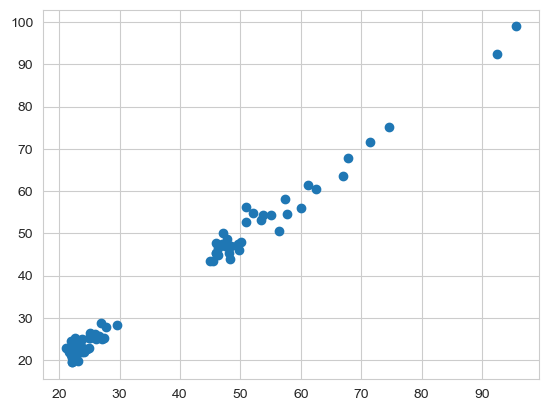

MAPE tR 1D: 4.57%


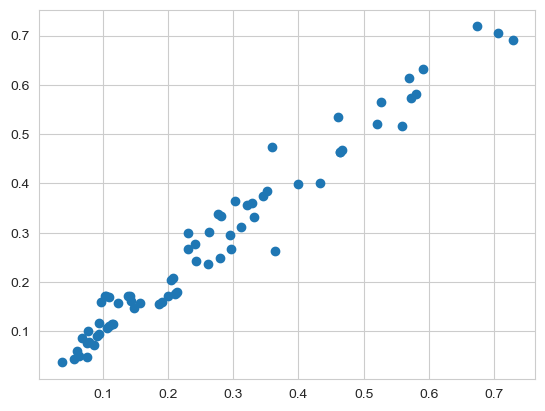

MAPE tR 2D: 11.80%


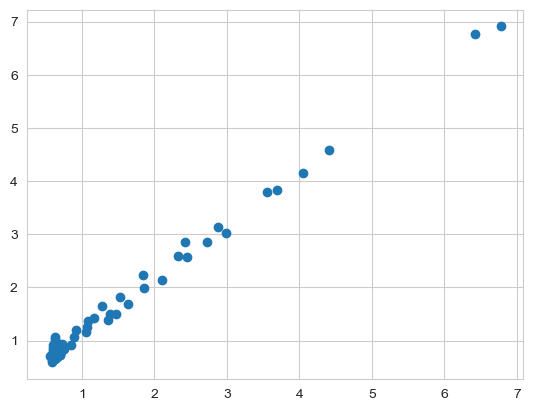

MAPE W 1D: 13.62%


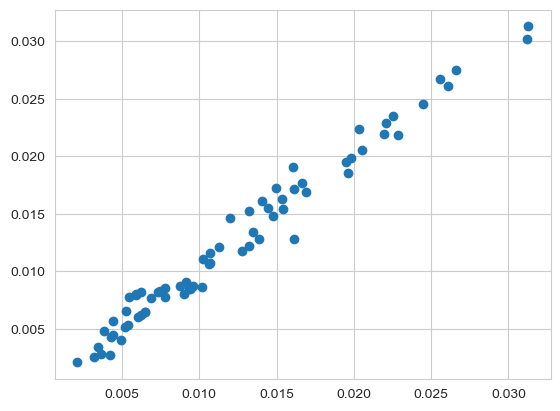

MAPE W 2D: 8.73%


In [13]:
# compare online and offline retention times
# remove_indices from online system
tR_list_1D_online2 = np.delete(tR_list_1D_online, remove_indices)
plt.plot(tR_list_1D_online2, tR_list_1D, 'o')
plt.show()
plt.close()

# compute mean absolute percentage error
MAPE = np.mean(np.abs(tR_list_1D_online2 - tR_list_1D) / tR_list_1D)
print('MAPE tR 1D: {:.2f}%'.format(MAPE * 100)) # was around 5-15% in previous AUTOLC work


# repeat for widths and 2D
tR_list_2D_online2 = np.delete(tR_list_2D_online, remove_indices)
plt.plot(tR_list_2D_online2, tR_list_2D, 'o')
plt.show()
plt.close()

# compute mean absolute percentage error
MAPE = np.mean(np.abs(tR_list_2D_online2 - tR_list_2D) / tR_list_2D)
print('MAPE tR 2D: {:.2f}%'.format(MAPE * 100)) # was around 15-40% in previous AUTOLC work

W_list_1D_online2 = np.delete(W_list_1D_online, remove_indices)
plt.plot(W_list_1D_online2, W_list_1D, 'o')
plt.show()
plt.close()

# compute mean absolute percentage error
MAPE = np.mean(np.abs(W_list_1D_online2 - W_list_1D) / W_list_1D)
print('MAPE W 1D: {:.2f}%'.format(MAPE * 100)) # was around 40% in previous AUTOLC work

W_list_2D_online2 = np.delete(W_list_2D_online, remove_indices)
plt.plot(W_list_2D_online2, W_list_2D, 'o')
plt.show()
plt.close()

# compute mean absolute percentage error
MAPE = np.mean(np.abs(W_list_2D_online2 - W_list_2D) / W_list_2D)
print('MAPE W 2D: {:.2f}%'.format(MAPE * 100))# was around 60% in previous AUTOLC work
